# Experimentation with Neural Turing Machines and two other models for sequence processing

Trying out 3 different models on 6 different datasets for algorithmic inference.

In [123]:
# Wire up the required libraries
import numpy as np                                                 # Array operations
import tensorflow as tf                                            # Deep learning
import tensorflow.keras as keras                                   # For simplified deep learning interface
from tensorflow.keras.models import Sequential                     # For building models
from tensorflow.keras.preprocessing.sequence import pad_sequences  # Data preprocessing
from sklearn.model_selection import train_test_split               # Data splitting
import tensorflow_models as tfm                                    # Models library for transformers
import keras_nlp as knlp                                           # For positional encoding
import pandas as pd                                                # Dataframe operations
import matplotlib.pyplot as plt                                    # Plot history
import seaborn as sns                                              # Improve plot aesthetics
import pickle                                                      # Save and training history
import sys                                                         # For system calls
sys.path.append('.')                                               # Add local modules to path
from ntm import NTMCell                                            # Local NTM implementation

# Custom layer to add positional encoding for the transformer model to use inside sequential Keras models
class EncodePositions(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EncodePositions, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.add(inputs, knlp.layers.SinePositionEncoding()(inputs))

# Common methods for all the experiments

# Plot the training history for each model
def plot_history(history):
    # Plot training history, placing the figures side-by-side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    # Plot training and validation loss
    ax1.plot(history.history['loss'], label='Training loss')
    ax1.plot(history.history['val_loss'], label='Validation loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.axhline(y=0.0, color='r', linestyle='--')
    ax1.legend()
    # Plot training and validation accuracy
    ax2.plot(history.history['accuracy'], label='Training accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.axhline(y=1.0, color='r', linestyle='--')
    fig.show()

# Common method for training each models, with fixed parameters
def train_model(model, X_train, y_train, X_val, y_val):
    # Callback to restore the best weights
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True, mode='min')
    # Train the model
    history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=1)
    return history

# Encode alphabet characters as one-hot vectors
def char_to_one_hot(char, num_chars, char_to_index):
    one_hot = np.zeros(num_chars)
    one_hot[char_to_index[char]] = 1
    return one_hot

# Encode a string as a one-hot matrix
def string_to_one_hot(string, num_chars, char_to_index):
    one_hot = np.zeros((len(string), num_chars))
    for i, char in enumerate(string):
        one_hot[i] = char_to_one_hot(char, num_chars, char_to_index)
    return one_hot

# Pad using keras pad_sequences
def pad_one_hot(one_hot, max_seq_len):
    return pad_sequences([one_hot], maxlen=max_seq_len, dtype='float32', padding='post', truncating='post')[0]

# Show the contents and shape of the processed data
def inspect_data(X_train, y_train, X_val, y_val, X_test, y_test):
    print("X_train shape: {}".format(X_train.shape))
    print("y_train shape: {}".format(y_train.shape))
    print("X_val shape: {}".format(X_val.shape))
    print("y_val shape: {}".format(y_val.shape))
    print("X_test shape: {}".format(X_test.shape))
    print("y_test shape: {}".format(y_test.shape))
    print("X_train example: {}".format(X_train[0][0:5]))
    print("y_train example: {}".format(y_train[0][0:5]))

# Common method to build the models, where input and output layers are fixed, but the core model is variable
def build_model(layers, input_shape, output_shape, activation):
    # First value is the max length of the one-hot vectors, and the second is the dimension of the alphabet
    model = Sequential()
    # Masking input layer to ignore padding
    model.add(keras.layers.Masking(mask_value=0., input_shape=input_shape))
    model.add(keras.layers.LayerNormalization())
    # The variable component of the model
    for layer in layers:
        model.add(layer)
    # Output and learning parameters
    model.add(keras.layers.Dense(output_shape, activation=activation))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build Neural Turing Machine model with approx 1700 trainable parameters in the basic version
def build_ntm(num_controller_units=6,  num_controller_layers=1,             # Memory controller parameters
              num_memory_locations=32, memory_location_size=8,              # Memory size parameters
              num_write_heads=1, num_read_heads=2,                          # Memory access parameters
              recurrent_output_dimension=8,                                 # Output dimension of the NTM
              input_shape=(22, 18), output_shape=2, activation='softmax'):  # Task-dependent configuration

    ntm_cell = NTMCell(num_controller_layers, num_controller_units,
                       num_memory_locations, memory_location_size,
                       num_read_heads, num_write_heads,
                       output_dim=recurrent_output_dimension)
    layer = keras.layers.RNN(ntm_cell, name='neural_turing_machine')
    model = build_model([layer], input_shape, output_shape, activation)
    ntm_cell.params_count()
    return model

# Build LSTM model with approx 1700 trainable parameters in the basic version
def build_lstm(nodes=13, input_shape=(22, 18), output_shape=2, activation='softmax'):
    return build_model([keras.layers.LSTM(nodes)], input_shape, output_shape, activation)

# Build Transformer model with approx 1700 trainable parameters in the basic version
def build_transformer(num_layers=1, num_attention_heads=1,intermediate_size=8,
                      input_shape=(22, 18), output_shape=2, activation='softmax'):
    transformer_layers = [
        # Add positional encoding as suggested in the paper https://arxiv.org/pdf/1706.03762.pdf
        EncodePositions(),
        # Main transformer layer, converting the input sequence to intermediate representations
        tfm.nlp.models.TransformerEncoder(num_layers=num_layers, num_attention_heads=num_attention_heads, intermediate_size=intermediate_size),
        # Reduce the converted sequence to a fixed length vector
        keras.layers.GlobalMaxPooling1D()
    ]
    return build_model(transformer_layers, input_shape, output_shape, activation)

# Compare models by training and plotting their validation loss
def compare_models(ntm_train_data, lstm_train_data, transformer_train_data, X_test, y_test):
    ntm_history = ntm_train_data.history
    lstm_history = lstm_train_data.history
    transformer_history = transformer_train_data.history
    plt.plot(ntm_history['val_loss'], label='NTM')
    plt.plot(lstm_history['val_loss'], label='LSTM')
    plt.plot(transformer_history['val_loss'], label='Transformer')
    plt.title('Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # Add baseline at y=0
    plt.axhline(y=0.0, color='r', linestyle='--')

    ntm_loss, _ = ntm_train_data.model.evaluate(X_test, y_test)
    lstm_loss, _ = lstm_train_data.model.evaluate(X_test, y_test)
    transformer_loss, _ = transformer_train_data.model.evaluate(X_test, y_test)

    plt.axhline(y=ntm_loss, color='g', linestyle='--')
    plt.axhline(y=lstm_loss, color='b', linestyle='--')
    plt.axhline(y=transformer_loss, color='r', linestyle='--')

    # Add label near minimums, placing it on the opposite side of the line
    plt.text(0, ntm_loss + 0.01, 'NTM: {:.4f}'.format(ntm_loss), color='g')
    plt.text(0, lstm_loss + 0.01, 'LSTM: {:.4f}'.format(lstm_loss), color='b')
    plt.text(0, transformer_loss + 0.01, 'Transformer: {:.4f}'.format(transformer_loss), color='r')

    plt.legend()
    plt.show()

# Select and save the model that achieved the best test loss after 5 training attempts
def determine_best_model(name, architecture, X_train, X_val, y_train, y_val, X_test, y_test, input_shape, output_shape, activation):
    best_history = None
    best_model = None
    best_loss = None

    # Try 5 times to counteract the randomness of the training
    for i in range(5):
        model = architecture(input_shape=input_shape, output_shape=output_shape, activation=activation)
        history = train_model(model, X_train, y_train, X_val, y_val)
        loss, _ = model.evaluate(X_test, y_test)

        if best_loss is None or loss < best_loss:
            best_history = history
            best_model = model
            best_loss = loss

    # Save model and history
    best_model.save(f"artefacts/best_{name}.h5")
    with open(f"artefacts/best_history_{name}.pkl", 'wb') as f:
        pickle.dump(best_history, f)

    # To load it back later
    # ntm = keras.models.load_model( 'artefacts/best_1_ntm.h5', custom_objects={'NTMCell': NTMCell})
    return best_history

# Run the experiment for a given dataset on all 3 models
def experiment(number, data_gen, holdout, input_shape, output_shape, activation):
    X_train, X_val, y_train, y_val, X_test, y_test = data_gen(holdout=holdout)

    with tf.device("/cpu:0"): # After NTM implementation to TF 2.0, we need to temporarily switch off GPU usage, because there were some performance issues
        ntm_history = determine_best_model(f"ntm_{number}", build_ntm, X_train, X_val, y_train, y_val, X_test, y_test, input_shape, output_shape, activation)
    lstm_history = determine_best_model(f"lstm_{number}", build_lstm, X_train, X_val, y_train, y_val, X_test, y_test, input_shape, output_shape, activation)
    transformer_history = determine_best_model(f"transformer_{number}", build_transformer, X_train, X_val, y_train, y_val, X_test, y_test, input_shape, output_shape, activation)

    compare_models(ntm_history, lstm_history, transformer_history, X_test, y_test)

# Check gpu availability for to speed up the training later
if tf.test.is_built_with_cuda() and bool(tf.config.list_physical_devices('GPU')):
    print("GPU support is available.")
else:
    print("No GPU support available.")

# Use seaborn's default style to make attractive graphs
sns.set()
%matplotlib inline

GPU support is available.


## Simple regex for time recognition, 1700 parameters

In [35]:
# Load and preprocess the data for the time recognition task
def time_task(holdout):
    # Convert alphabet into one-hot vectors
    alphabet = "0123456789APapMm: "
    num_chars = len(alphabet)
    char_to_index = dict((c, i) for i, c in enumerate(alphabet))

    # Load the created data
    df = pd.read_csv('time.csv')

    # Convert true/false to categorical using keras.utils.to_categorical
    df['valid_int'] = df['valid'].apply(lambda x: 1 if x else 0)
    df['valid_one_hot'] = keras.utils.to_categorical(df['valid_int']).tolist()

    # Convert the time strings to one-hot vectors and pad them to the max length with null characters
    df['time_one_hot'] = df['string'].apply(lambda x: string_to_one_hot(x, num_chars, char_to_index))
    # Find the max length of the one-hot vectors
    max_seq_len = df['time_one_hot'].apply(lambda x: x.shape[0]).max()
    df['time_one_hot'] = df['time_one_hot'].apply(lambda x: pad_one_hot(x, max_seq_len))

    # Extract columns to make the data easier to work with
    X = np.stack(df['time_one_hot'].values)
    y = np.stack(df['valid_one_hot'].values)

    # Split the data into training and testing sets, preserving the ratio of valid/invalid times
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=holdout, stratify=y, random_state=43)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=holdout, stratify=y_train_val, random_state=43)

    # Illustrate the data
    inspect_data(X_train, y_train, X_val, y_val, X_test, y_test)
    return X_train, X_val, y_train, y_val, X_test, y_test

### Experiment 1: Sufficient available data

X_train shape: (7200, 22, 18)
y_train shape: (7200, 2)
X_val shape: (4800, 22, 18)
y_val shape: (4800, 2)
X_test shape: (8000, 22, 18)
y_test shape: (8000, 2)
X_train example: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
y_train example: [0. 1.]
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_7 (Masking)         (None, 22, 18)            0         
                                                                 
 layer_normalization_7 (Laye  (None, 22, 18)           36        
 rNormalization)                                                 
                                                                 
 neural_turing_machine (RNN) 

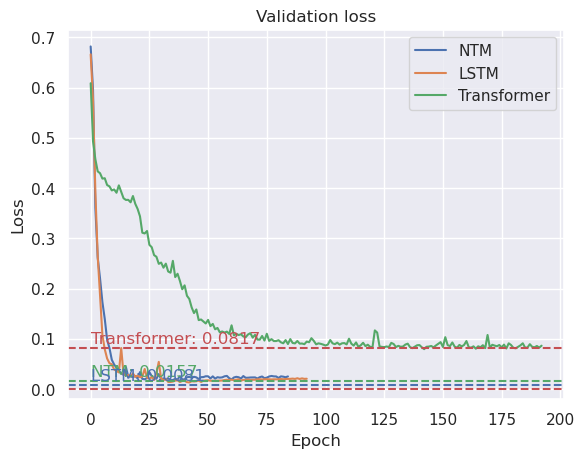

In [13]:
# Large training dataset with low holdout share, 7200 examples
experiment(1, time_task, 0.4, input_shape=(22, 18), output_shape=2, activation='softmax')

### Experiment 2: Limited available data

X_train shape: (800, 22, 18)
y_train shape: (800, 2)
X_val shape: (3200, 22, 18)
y_val shape: (3200, 2)
X_test shape: (16000, 22, 18)
y_test shape: (16000, 2)
X_train example: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]
y_train example: [1. 0.]
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_38 (Masking)        (None, 22, 18)            0         
                                                                 
 layer_normalization_38 (Lay  (None, 22, 18)           36        
 erNormalization)                                                
                                                                 
 neural_turing_machine (RNN)

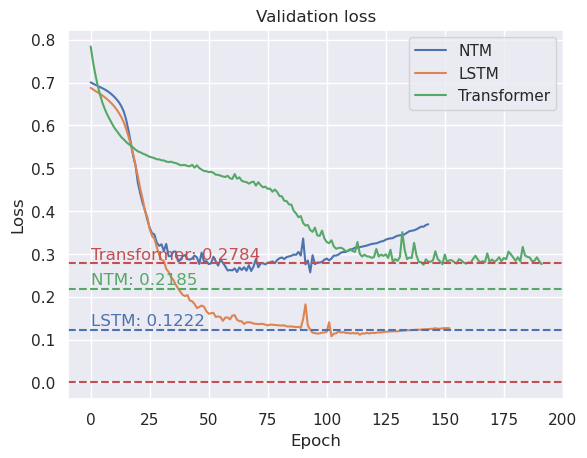

In [18]:
# Small training dataset with high holdout share, 800 examples
experiment(2, time_task, 0.8, input_shape=(22, 18), output_shape=2, activation='softmax')

## Complex regex for ip recognition

In [36]:
def ipv6_task(holdout):
    # Convert alphabet into one-hot vectors
    alphabet = "0123456789abcdefABCDEF: "
    num_chars = len(alphabet)
    char_to_index = dict((c, i) for i, c in enumerate(alphabet))

    df = pd.read_csv('ipv6.csv')

    # Convert true/false to categorical using keras.utils.to_categorical
    df['valid_int'] = df['valid'].apply(lambda x: 1 if x else 0)
    df['valid_one_hot'] = keras.utils.to_categorical(df['valid_int']).tolist()

    # Convert the time strings to one-hot vectors and pad them to the max length with null characters
    df['ipv6_one_hot'] = df['string'].apply(lambda x: string_to_one_hot(x, num_chars, char_to_index))
    # Find the max length of the one-hot vectors
    max_seq_len = df['ipv6_one_hot'].apply(lambda x: x.shape[0]).max()
    df['ipv6_one_hot'] = df['ipv6_one_hot'].apply(lambda x: pad_one_hot(x, max_seq_len))

    # The same lines as above, but with a cycle

    # Extract columns to make the data easier to work with
    X = np.stack(df['ipv6_one_hot'].values)
    y = np.stack(df['valid_one_hot'].values)

    # Split the data into training and testing sets, preserving the ratio of valid/invalid times
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=holdout, stratify=y, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=holdout, stratify=y_train_val, random_state=42)

    inspect_data(X_train, y_train, X_val, y_val, X_test, y_test)
    return X_train, X_val, y_train, y_val, X_test, y_test

### Experiment 3: Sufficient available data

X_train shape: (7200, 95, 24)
y_train shape: (7200, 2)
X_val shape: (4800, 95, 24)
y_val shape: (4800, 2)
X_test shape: (8000, 95, 24)
y_test shape: (8000, 2)
X_train example: [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
y_train example: [0. 1.]
Model: "sequential_102"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_102 (Masking)       (None, 95, 24)            0         
                                                                 
 layer_normalization_102 (La  (None, 95, 24)           48        
 yerNormalization)                                               
   

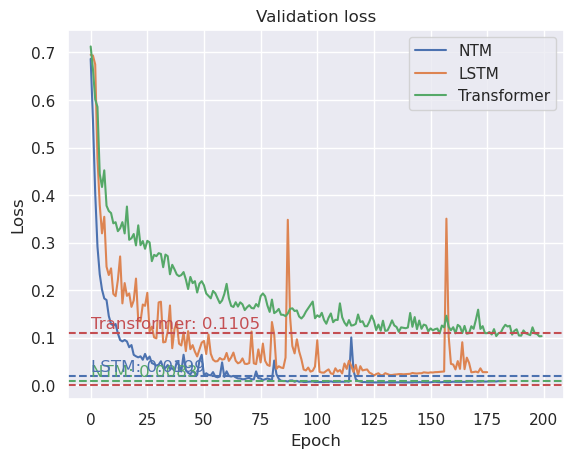

In [40]:
# Large training dataset with low holdout share, 7200 examples
experiment(3, ipv6_task, 0.4, input_shape=(95, 24), output_shape=2, activation='softmax')

### Experiment 4: Limited available data

X_train shape: (800, 92, 24)
y_train shape: (800, 2)
X_val shape: (3200, 92, 24)
y_val shape: (3200, 2)
X_test shape: (16000, 92, 24)
y_test shape: (16000, 2)
X_train example: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
y_train example: [0. 1.]
Model: "sequential_118"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_118 (Masking)       (None, 92, 24)            0         
                                                                 
 layer_normalization_118 (La  (None, 92, 24)           48        
 yerNormalization)                                               
   

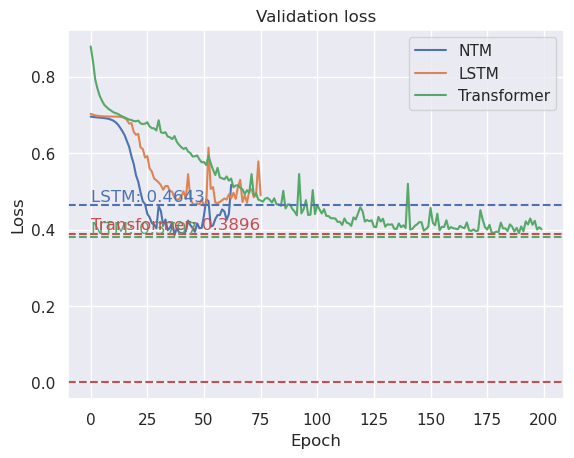

In [48]:
# Small training dataset with high holdout share
experiment(4, ipv6_task, 0.8, input_shape=(92, 24), output_shape=2, activation='softmax')

## The 3rd task. List-processing algorithm

In [131]:
def list_task(holdout):
    # Load df from lst.pkl
    df = pd.read_pickle('lst.pkl')
    X = df['X'].values
    y = df['y'].values

    # Pad all X to the same length
    max_len = max([len(x) for x in X])
    X = pad_sequences(X, maxlen=max_len, padding='post', dtype='float32')

    X = np.stack(X)
    y = np.stack(y)

    # Split the data into training and testing sets, preserving the ratio of valid/invalid times
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=holdout, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=holdout, random_state=42)

    inspect_data(X_train, y_train, X_val, y_val, X_test, y_test)
    return X_train, X_val, y_train, y_val, X_test, y_test

In [134]:
# Make an attempt to solve the third task
# We need more layers and more computing power to solve it

X_train, X_val, y_train, y_val, X_test, y_test = list_task(holdout=0.2)

model =build_ntm(input_shape=(14, 1), output_shape=2, activation='sigmoid')
history = train_model(model, X_train, y_train, X_val, y_val)
loss, _ = model.evaluate(X_test, y_test)

X_train shape: (12800, 14)
y_train shape: (12800, 2)
X_val shape: (3200, 14)
y_val shape: (3200, 2)
X_test shape: (4000, 14)
y_test shape: (4000, 2)
X_train example: [0.439 0.47  0.306 0.43  0.187]
y_train example: [0.71428571 0.85714286]
Model: "sequential_160"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_160 (Masking)       (None, 14, 1)             0         
                                                                 
 layer_normalization_143 (La  (None, 14, 1)            2         
 yerNormalization)                                               
                                                                 
 neural_turing_machine (RNN)  (None, 64)               383248    
                                                                 
 dense_661 (Dense)           (None, 2)                 130       
                                                                 
Total param